# MR-Longitudinal Radiomics
### Radiomics pipeline created for longitudinal images collected at subsequent fractions of treatment.
##### Full model: Feature Extraction, Feature Reduction via volume correlation & test-retest stability, Feature Selection via Euclidean distance between feature pair trajectories and hierachical clustering.
##### Compares the results of the longitudinal model with a standard delta-radiomics approach to illustrate the importance of accounting for the full feature trajectory over treatment.

###
#### Below specify certain variables and options for customising the notebook

In [10]:
import os
import pandas as pd
from tqdm import tqdm

# Specify the output path
# specify the tag to use - could be anything, helps to identify the output if running multiple models
# default is "Test"
tag = "Long-Test"
# output_path = "C:/Users/b01297ar/Documents/ProstateMRL-local/ProstateMRL-Radiomics/ReleaseCode/Output/" + tag + "/"
cwd = os.getcwd()
output_path = cwd + "/Output/" 
if os.path.exists(output_path) == False:
        os.mkdir(output_path)
if os.path.exists(output_path + tag) == False:
    os.mkdir(output_path + tag)
    os.mkdir(output_path + tag + "/Features/")
    os.mkdir(output_path + tag + "/Extraction/")
    os.mkdir(output_path + tag + "/Plots/")
output_path = cwd + "/Output/" + tag + "/"

# specify if you want to compare to a delta model
# default is False
Delta_Model = False

# Specify if you want to visualise the results in plots
# default is False, can specify at given stages below if you want to visualise
plot = False

# Specify if you want to extract Features
# default is False, option to do so is below
# If features are already extracted, set to false and provide the path to the extracted features below
extract = False


In [11]:
# import pandas as pd
# import os

# MS_df = pd.read_csv("/data/t/Aaron/ProstateMRL/Data/MSContours.csv", sep=",", encoding='cp1252')
# MS_df["PatID"] = MS_df["PatID"].astype(str)
# MS_pats = MS_df["PatID"].unique()

# cwd = os.getcwd()

# key_df = pd.read_csv("/data/t/Aaron/ProstateMRL/Data/LimbusKey.csv")
# key_df["Contour"] = "RP"
# key_df["PatID"] = key_df["PatID"].astype(str)

# # if patid in MS_pats and key_df["PatID"] == patid change contour to MS
# for i in range(len(key_df)):
#     if key_df["PatID"][i] in MS_pats:
#         key_df["Contour"][i] = "MS"

# key_df["ContourType"] = "Manual"
# key_df["ImagePath"] = key_df["ImagePath"].str.replace("\\", "/")
# key_df["ImagePath"] = key_df["ImagePath"].str.replace("D:/data/", "/data/t/")
# key_df["ImagePath"] = key_df["ImagePath"].str.replace("HM-FSTP", "HM-FS")

# key_df["MaskPath"] = key_df["ImagePath"].str.replace("HM-FS", "Masks")

# # replace masks.nii with mask value for that patient
# for i in range(len(key_df)):
#     key_df["MaskPath"][i] = key_df["MaskPath"][i].replace("Masks.nii", key_df["Contour"][i] + "_pros.nii")

# #key_df["MaskPath"] = key_df["MaskPath"].str.replace("_Masks.nii", "_" + )
# key_df = key_df[['PatID', 'Fraction', 'Scan','Contour', 'ContourType', 'ImagePath', 'MaskPath']]

In [12]:
# key_df.to_csv(cwd + "/Input/Default/PepKey_Man.csv", index=False)

In [13]:
# # fix mask and image paths

# key_df = pd.read_csv(cwd + "/Input/Default/PepKey_Man.csv")

# for i in range(len(key_df)):
#     # some patids are missing a 0 at the start of the paths
#     path_ID = key_df["ImagePath"][i].split("/")[6]
#     mask_file = key_df["MaskPath"][i].split("/")[-1]
#     image_file = key_df["ImagePath"][i].split("/")[-1]
#     mask_fix = mask_file.replace(mask_file.split("_")[0], path_ID)
#     image_fix = image_file.replace(image_file.split("_")[0], path_ID)

#     key_df["MaskPath"][i] = key_df["MaskPath"][i].replace(mask_file, mask_fix)
#     key_df["ImagePath"][i] = key_df["ImagePath"][i].replace(image_file, image_fix)
    

# key_df.to_csv(cwd + "/Input/Default/PepKey_Man.csv", index=False)

In [14]:
# limbus_df = key_df.copy()

# limbus_df["Contour"] = "Limbus"
# limbus_df["ContourType"] = "Auto"

# for i in range(len(limbus_df)):
#     limbus_df["MaskPath"][i] = "/data/t/prostateMR_radiomics/PatPacks/P1-LimbusMasks/" + str(limbus_df["PatID"][i]) + "_" + str(limbus_df["Fraction"][i]) + ".nii"
    

# limbus_df.to_csv(cwd + "/Input/Default/PepKey_Lim.csv", index=False)

## Feature Extraction
#### If you want to extract features, provide a csv containing the following:
####               | PatID | Fraction | Image file | Mask Name | Mask file | 
#### Specify the root of the csv in the Input dir.
#### Calculates features based on the parameter file specified. Default setting is currently set at PyRadiomics base extraction parameters - Fixed bin size (FBS) of 25, no resampling, no normalisation, 107 features (IBSI compliant) and no wavelet/laplacian filters applied. 
#### Features are then calculated and then saved in a new folder in the Output dir - with files in parquet format. Columns will be:
#### PatID | Fraction | Mask | Feature | Feature Value |

In [15]:
from Functions import Extraction as FE

if extract == True:
    
    key_extraction = cwd + "/Input/Default/PepKey_Man.csv"
    key_extraction = pd.read_csv(key_extraction)

    extraction_path = output_path + "/Extraction/"
    if not os.path.exists(extraction_path):
        os.makedirs(extraction_path)

    params_extractor = cwd + "/Input/Default/Default_ExtractionParams.yaml"


    # Loop over all patients
    print("Extracting features for patients...")
    for pat in key_extraction["PatID"].unique():
        print("Processing patient: " + str(pat) + "...")

        # Get the patient's key
        key_pat = key_extraction[key_extraction["PatID"] == pat]
        Features_pat = pd.DataFrame()
        # loop over all rows
        if os.path.exists(output_path + "/Extraction/Manual_" + str(pat) + "_" + tag + ".csv"):
            print(" ")

        else:
            for i, row in key_pat.iterrows():


                PatID = row["PatID"]
                Fraction = row["Fraction"]
                Mask = row["Contour"]
                ContourType = row["ContourType"]
                ImagePath = row["ImagePath"]
                MaskPath = row["MaskPath"]
                
                # Extract features
                Features = FE.ExtractFeatures(PatID, Fraction, Mask, ContourType, ImagePath, MaskPath, params_extractor)

                Features_pat = Features_pat.append(Features)
            
                
            Features_pat.to_csv(output_path + "/Extraction/" + ContourType + "_" + str(pat) + "_" + tag + ".csv", index=False)


#### Once all features have been extracted, combine in to one dataframe
#### Or
#### Specify the path of the feature values. 
##### Default is to read in a parquet file (smaller file sizes - so quicker), make sure to change to pd.read_csv if reading in csv and change path.

In [18]:
# Combine all patients
df_all = pd.DataFrame()
if extract == True:
    files = os.listdir(output_path + "/Extraction/")
    for file in files:
        if file.endswith(".csv"):
            df_pat = pd.read_csv(output_path + "/Extraction/" + file)
            df_all = df_all.append(df_pat)
            

    # Save the features to parquet
    if os.path.exists(output_path + "/Features/") == False:
        os.mkdir(output_path + "/Features/")   
    df_all.to_csv(output_path + "/Features/Features_" + tag + ".csv")

# Specify the path to the features  
else:
    # Features_all = pd.read_parquet(output_path + "/Features/Features_" + tag + ".parquet")    
    # Features_all = pd.read_csv("E:/Aaron/ProstateMRL/Data/Paper1/HM-FS/Features/Longitudinal_All_fts_Baseline.csv")
    # df_all = pd.read_csv("C:/Users/b01297ar/Documents/ProstateMRL-local/ProstateMRL-Radiomics/Data/FeatureData/Longitudinal_All_fts_Baseline.csv")
    df_all = pd.read_csv(cwd + "/Output/" + tag + "/Features/Features_Baseline.csv")
# df_all.drop(["Unnamed: 0"], axis = 1, inplace = True)
df_all = pd.read_csv(cwd + "/Output/" + tag + "/Features/Features_" + tag + ".csv")
df_all.drop(["Unnamed: 0"], axis = 1, inplace = True)
df_all["Feature"] = df_all["Feature"].str.replace("original_", "")
df_all.head()

# df_ICC = pd.read_csv("C:/Users/b01297ar/Documents/ProstateMRL-local/ProstateMRL-Radiomics/Data/FeatureData/Longitudinal_Limbus_fts_Baseline.csv")
# df_ICC.drop(["Unnamed: 0"], axis = 1, inplace = True)
# remove first order min and max
df_all = df_all[~df_all["Feature"].isin(["firstorder_Minimum", "firstorder_Maximum"])]

df_man = df_all.loc[df_all["ContourType"] == "Manual"]
auto_pats = df_all.loc[df_all["Contour"] == "Limbus"]["PatID"].values
df_auto = df_all.loc[df_all["PatID"].isin(auto_pats)]

In [ ]:
print("Number of patients: " + str(len(df_all["PatID"].unique())))

Number of patients: 1


# Feature Reduction
#### Due to the high dimensionnality of radiomics values, it is vital that some of the features are removed if they offer no unique information. 
#### Since features are calculated by applying different formulas to images, many of these formulas are similar and so some features can be quite similar. We aim to remove all redundant features - redundant features in this model are those that are strongly correlated to volume, Spearman Rank coefficient rho > 0.6 and unstable due to contour differences, as measured by an ICC value < 0.5.

In [ ]:
from Functions import Reduction as FR

## Volume Correlation
#### Previous studies have shown that radiomic feature values have a strong correlation with the volume of the mask




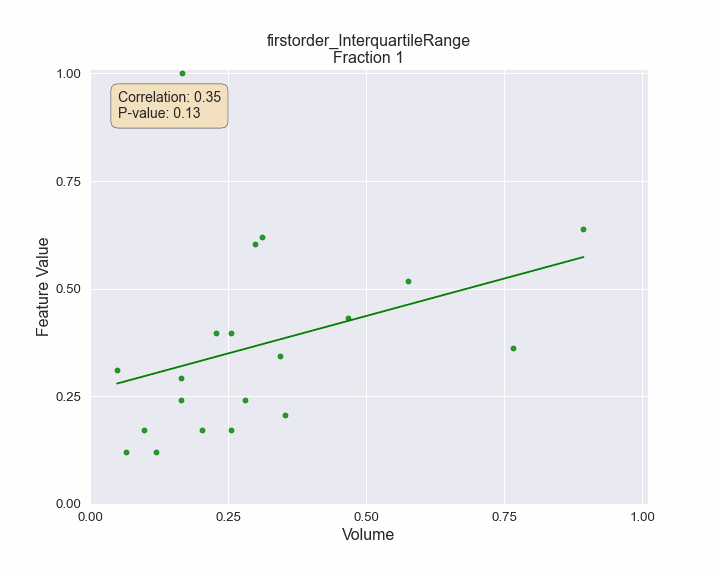

In [ ]:
import base64
from IPython.display import HTML, display
gif_path = cwd + "/NotebookFigures/VolCorr.gif"
b64 = base64.b64encode(open(gif_path, 'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width="500" height="400" align = "center" >'))

In [ ]:
# calculate volume correlation
FR.Volume(df_man, output_path, plot=True)

------------------------------
Volume Correlation
Correlating features to volume...


100%|██████████| 105/105 [00:00<00:00, 773.33it/s]


Volume redundant features: 27/105
------------------------------
Plotting volume correlation...


100%|██████████| 105/105 [00:48<00:00,  2.17it/s]

------------------------------


## ICC Stability
#### Intra-class correlation coefficient is used as a statistical measure of how much two observed quantities within a group tend to agree with each other. 
#### Been used widely within radiomics studies as a test-retest stability measure between two delineations.



In [ ]:
FR.ICC(df_auto, output_path, plot=True)

------------------------------
Stability Test
Calculating ICC...


  0%|          | 0/105 [00:00<?, ?it/s]

100%|██████████| 105/105 [00:02<00:00, 42.44it/s]


ICC redudant features: 26/105
------------------------------
Plotting ICC Values...


100%|██████████| 105/105 [00:39<00:00,  2.66it/s]

------------------------------


#### Remove redundant features

#### Still need to do further feature reduction

In [ ]:
df_all = FR.RemoveFts(df_all, output_path)

------------------------------
Removing redundant features...
Number of features removed: 43
Number of features remaining: 62
------------------------------


## Clustering I - Distance between Feature Trajectories
#### Calculate the Euclidean distance between feature pairs.
#### Distance values can then be used to visualise the relationship between features.
#### Can also be used to group features together.

In [ ]:
from Functions import Clustering as Cl
Cl.DistanceMatrix(df_all, output_path, True)

Calculating Euclidean distance between feature pair trajectories...


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


## Clustering II - Grouping Features
#### Hierarchical clustering using SciPy
####   - Weighted linkage (Refers to the algorithm by which clusters are formed)
####   - Starting T-val = 2 (Refers to the threshold value for which to go to a different cluster, i.e. how far away a value is to a cluster before a new cluster is created/put in another cluster.)
##### Clusters with < 3 features discarded as deemed too unstable.
##### Clusters with > 10 features re-clustered to subclusters. 


In [ ]:
Cl.ClusterFeatures(df_all, output_path, 2)

------------------------------
Clustering Feature Trajectories...


100%|██████████| 20/20 [00:00<00:00, 25.02it/s]

------------------------------


## Clustering III - Feature Selection
#### Cross-correlation value between feature trajectories within each cluster performed to determine most “representative” feature
####    - Highest mean cross-correlation passed through.
####    - Top 20% of features.
#### Each patient passes through a set of features.
#### Features then tallied up and the top 10 ranked features are selected.


In [ ]:
Cl.FeatureSelection(df_all, output_path)

------------------------------
Feature Selection
Calculating Cross-Correlation values...


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]

------------------------------
Selected Features: 
glcm_JointEntropy
glrlm_GrayLevelVariance
glcm_Idn
glcm_DifferenceAverage
firstorder_MeanAbsoluteDeviation
firstorder_RootMeanSquared
glcm_JointEnergy
glrlm_ShortRunEmphasis
glcm_SumSquares
glcm_DifferenceVariance
gldm_HighGrayLevelEmphasis
gldm_LargeDependenceEmphasis
firstorder_Uniformity
------------------------------
Number of Selected Features: 13
------------------------------


In [ ]:
L_fts = pd.read_csv(output_path + "/Features/Features_Selected.csv")
D_fts = pd.read_csv("/home/arn/Radiomics/Paper1-Release/Output/Delta-Test/Features/Features_Selected.csv")

L_fts = L_fts["Feature"].values
D_fts = D_fts["Feature"].values

# get the features that are in both
fts = [x for x in L_fts if x in D_fts]

print("Number of features in both: " + str(len(fts)))
for ft in fts:
    print(ft)

Number of features in both: 1
glrlm_GrayLevelVariance
